# Percobaan 2

proses yang digunakan:
1. mengambil V channel dari gambar
2. melakukan ekualisasi histogram
3. melakukan konvolusi dengan kernel sharpening
4. melakukan proses gaussian blur

In [160]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [161]:
data = []
file_name = []
datalabel = []
path = []
data_distribution = {}

for label in os.listdir("dataset"):
    label_path = os.path.join("dataset", label)
    if not os.path.isdir(label_path):
        continue
    images = os.listdir(label_path)
    data_distribution[label] = len(images)
    print(f"Memproses label: {label}, jumlah gambar: {len(images)}")

    for filename in images:
        img_path = os.path.join(label_path, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (350, 350))
            data.append(img)
            datalabel.append(label)  
            file_name.append(filename)
            path.append(img_path)

print("Data: ", len(data))
print("Label: ", len(datalabel))
print("Filenames: ", len(file_name))
print("Data Distribution: ", data_distribution)


Memproses label: ripe, jumlah gambar: 110
Memproses label: rotten, jumlah gambar: 110
Memproses label: unripe, jumlah gambar: 110
Data:  330
Label:  330
Filenames:  330
Data Distribution:  {'ripe': 110, 'rotten': 110, 'unripe': 110}


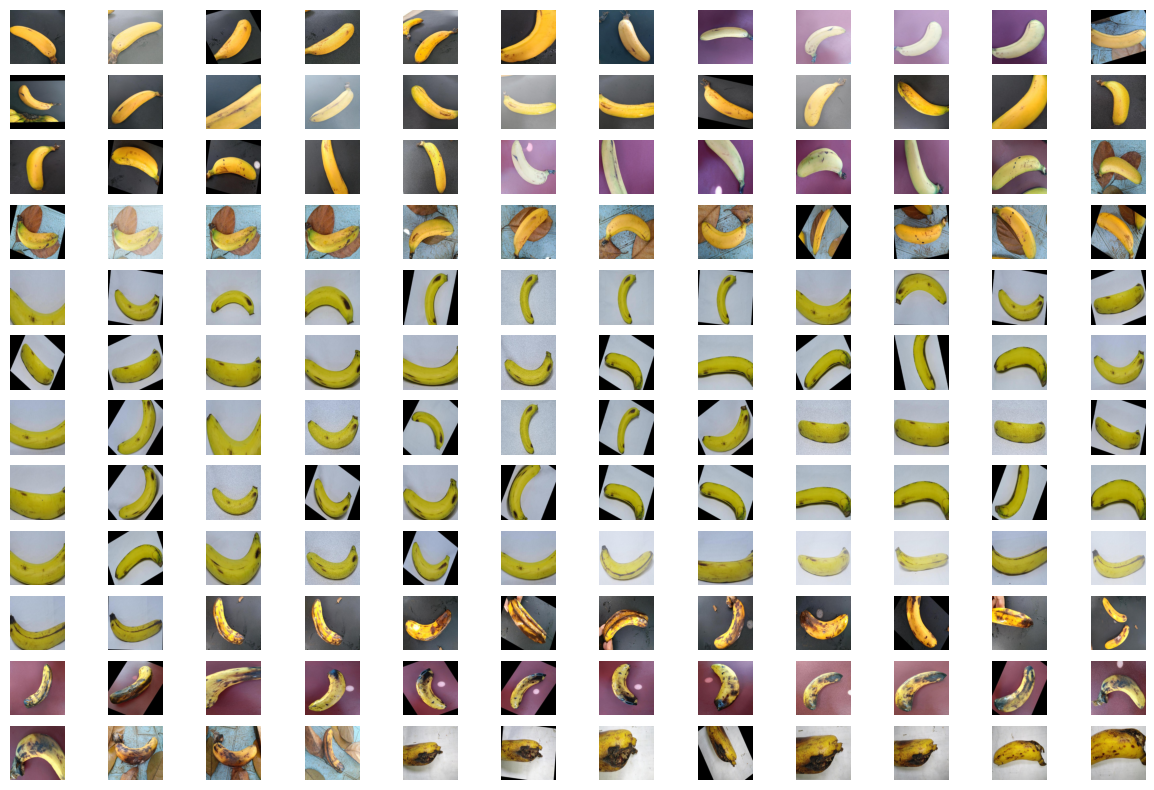

In [162]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(15, 10))
    for i in range(1, row * column + 1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i - 1])
        plt.axis('off')  
    plt.show()
displayImg(12,12, data)

## Data Augmentation

### Define Augmentation Function


In [163]:
data_augmented = [] 
labels_augmented = []
file_name_augmented = []

def flip_horizontal(image):
    return np.fliplr(image)

def rotate(image):
    return np.rot90(image, k=3)  

for i in range(len(data)):
    original = data[i]
    flipped = flip_horizontal(original)
    rotated = rotate(original)

    data_augmented.extend([flipped, rotated])
    labels_augmented.extend([datalabel[i]] * 2)
    file_name_augmented.extend([file_name[i] + '_flip', file_name[i] + '_rot'])

print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(data_augmented))


Jumlah data sebelum augmentasi: 330
Jumlah data setelah augmentasi: 660


## Data Preparation

### Define Preprocessing Function


In [164]:
kernel_sharpening = np.array([[1/9,1/9,1/9],
                              [1/9,8/9,1/9],
                              [1/9,1/9,1/9]])

In [165]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    k = size // 2
    kernel = np.zeros((size, size), dtype=np.float32)

    for y in range(-k, k + 1):
        for x in range(-k, k + 1):
            kernel[y + k, x + k] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    kernel /= np.sum(kernel)
    return kernel

def clip(array: np.ndarray, min_val: float, max_val: float) -> np.ndarray:
    result = array.copy()
    result[result < min_val] = min_val
    result[result > max_val] = max_val
    return result


In [166]:
def rgb_to_v_channel(img_rgb):
    img_rgb = img_rgb.astype('float32') / 255.0
    height, width, _ = img_rgb.shape
    V_channel = np.zeros((height, width), dtype='float32')

    for y in range(height):
        for x in range(width):
            r, g, b = img_rgb[y, x]
            mx = max(r, g, b)
            V_channel[y, x] = mx

    return (V_channel * 255).astype(np.uint8)

def histogram_equalization(v_channel):
    hist = np.zeros(256, dtype=int)
    for y in range(v_channel.shape[0]):
        for x in range(v_channel.shape[1]):
            hist[v_channel[y, x]] += 1

    cdf = np.cumsum(hist)
    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = v_channel.size

    equalized = np.zeros_like(v_channel)
    for i in range(256):
        new_value = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * 255)
        equalized[v_channel == i] = new_value

    return equalized.astype(np.uint8)

def konvolusi(image, kernel):
    height, width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height //2, kernel_width //2

    padded =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([height, width])

    for i in range(height):
        for j in range(width):
            region = padded[i:i+kernel_height, j:j+kernel_width]
            
            result[i, j] = np.sum(region * kernel)
    return result

def gaussian_blur(img: np.ndarray, kernel_size: int = 5, sigma: float = 1.0) -> np.ndarray:
    height, width = img.shape
    k = kernel_size // 2
    kernel = gaussian_kernel(kernel_size, sigma)

    padded_img = np.pad(img, ((k, k), (k, k)), mode='reflect')
    output = np.zeros_like(img, dtype=np.float32)

    for y in range(height):
        for x in range(width):
            region = padded_img[y:y+kernel_size, x:x+kernel_size]
            output[y, x] = np.sum(region * kernel)

    return clip(output, 0, 255).astype(np.uint8)

Ripe Samples


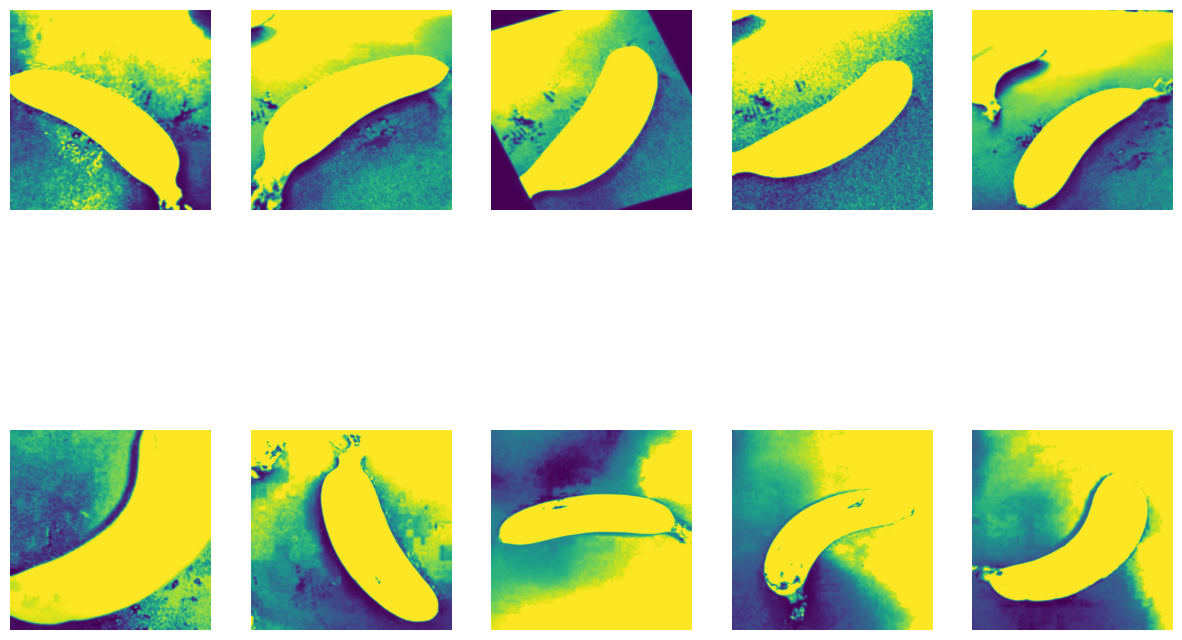

Unripe Samples


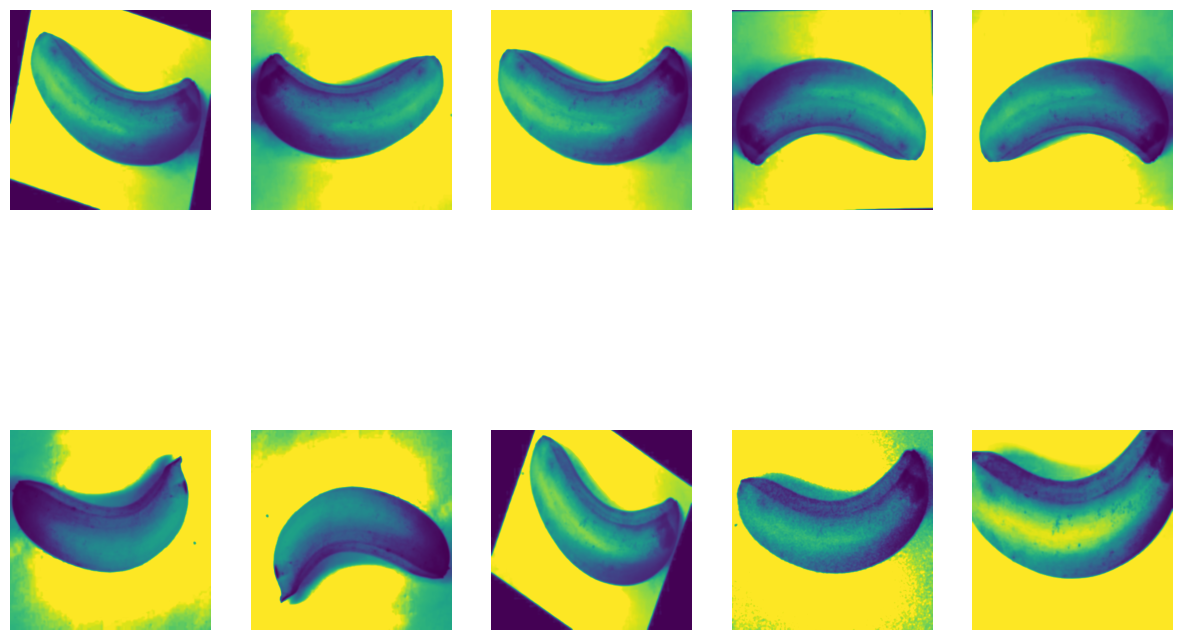

Rotten Samples


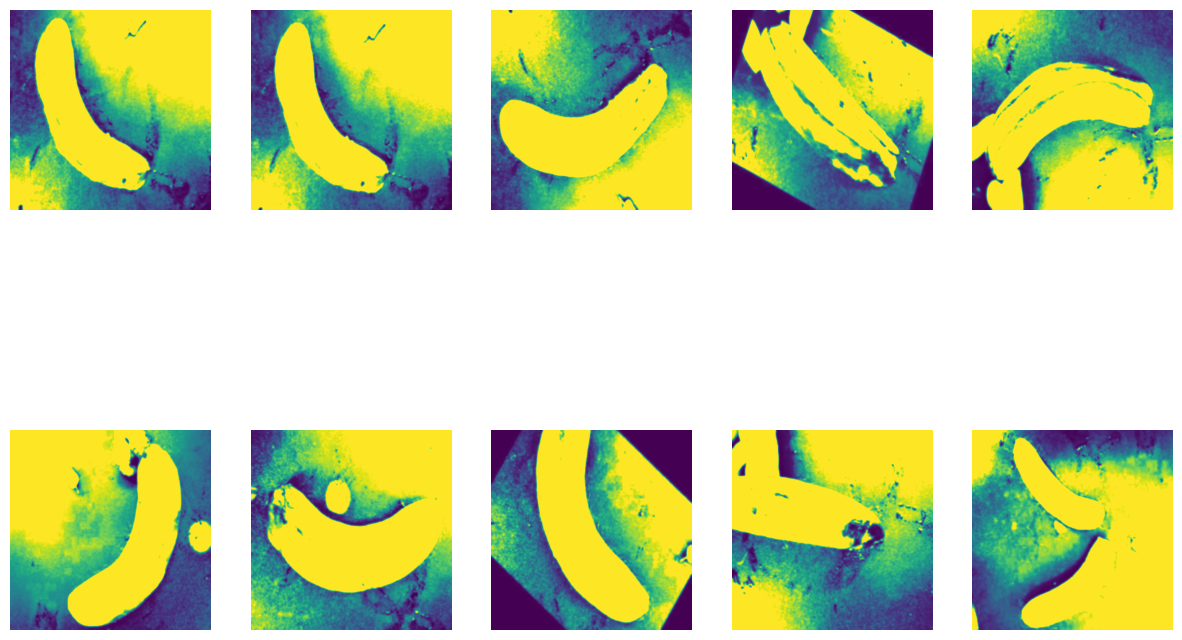

In [167]:
ripe = []
unripe = []
rotten = []


for i in range(len(data)):
    if datalabel[i].lower() == 'ripe' and len(ripe) < 10:
        proc = rgb_to_v_channel(data[i])
        proc = histogram_equalization(proc)
        proc = konvolusi(proc, kernel_sharpening)
        proc = gaussian_blur(proc, kernel_size=5, sigma=1.0)
        ripe.append(proc)
        
    elif datalabel[i].lower() == 'unripe' and len(unripe) < 10:
        proc = rgb_to_v_channel(data[i])
        proc = histogram_equalization(proc)
        proc = konvolusi(proc, kernel_sharpening)
        proc = gaussian_blur(proc, kernel_size=5, sigma=1.0)
        unripe.append(proc)

    elif datalabel[i].lower() == 'rotten' and len(rotten) < 10:
        proc = rgb_to_v_channel(data[i])
        proc = histogram_equalization(proc)
        proc = konvolusi(proc, kernel_sharpening)
        proc = gaussian_blur(proc, kernel_size=5, sigma=1.0)
        rotten.append(proc)

    if len(ripe) >= 10 and len(unripe) >= 10 and len(rotten) >= 10:
        break

print("Ripe Samples")
displayImg(2, 5, ripe)

print("Unripe Samples")
displayImg(2, 5, unripe)

print("Rotten Samples")
displayImg(2, 5, rotten)



### Preprocessing

In [168]:
dataPreprocessed = []
for i in range(len(data_augmented)):
    proc = rgb_to_v_channel(data_augmented[i])
    proc = histogram_equalization(proc)
    proc = konvolusi(proc, kernel_sharpening)
    proc = gaussian_blur(proc, kernel_size=5, sigma=1.0)

    dataPreprocessed.append(proc.astype(np.uint8))

### Feature Extraction

In [169]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [170]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [171]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [172]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [173]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [174]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [175]:
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]

In [176]:
def entropyGlcm(matrix):
    glcm_array = matrix[:, :, 0, 0]
    return entropy(glcm_array.flatten())


In [177]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [178]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [179]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [180]:
for i in range(len(data_augmented)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [181]:
for i in range(len(data_augmented)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [182]:
for i in range(len(data_augmented)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [183]:
for i in range(len(data_augmented)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [184]:
for i in range(len(data_augmented)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [185]:
for i in range(len(data_augmented)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [186]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,musa-acuminata-banana-ad772802-394a-11ec-996c-...,ripe,90.378600,213.663123,95.613885,134.730946,0.545855,0.509964,0.541353,0.514032,...,0.187039,0.186841,0.434199,0.430040,0.432481,0.432251,0.992899,0.983194,0.992496,0.989403
1,musa-acuminata-banana-ad772802-394a-11ec-996c-...,ripe,95.613885,213.663123,90.378600,134.730946,0.541353,0.509964,0.545855,0.514032,...,0.188529,0.186841,0.432481,0.430040,0.434199,0.432251,0.992496,0.983194,0.992899,0.989403
2,musa-acuminata-banana-adb78123-394a-11ec-93c6-...,ripe,60.627302,84.391450,79.101400,178.777325,0.576650,0.547497,0.559820,0.527376,...,0.188159,0.186550,0.436525,0.435256,0.433773,0.431914,0.995274,0.993422,0.993827,0.986066
3,musa-acuminata-banana-adb78123-394a-11ec-93c6-...,ripe,79.101400,84.391450,60.627302,178.777325,0.559820,0.547497,0.576650,0.527376,...,0.190554,0.186550,0.433773,0.435256,0.436525,0.431914,0.993827,0.993422,0.995274,0.986066
4,musa-acuminata-banana-addcca4d-394a-11ec-b76c-...,ripe,59.241261,103.385416,77.239484,156.355490,0.626371,0.591984,0.619225,0.587837,...,0.158775,0.156663,0.398546,0.398379,0.398466,0.395806,0.996782,0.994366,0.995800,0.991479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,musa-acuminata-unripe-7fecfc48-1d0a-11ec-b38a-...,unripe,38.830978,57.769460,25.702652,67.187067,0.624078,0.587430,0.627872,0.580112,...,0.195816,0.192458,0.442118,0.439847,0.442511,0.438701,0.997224,0.995877,0.998164,0.995205
656,musa-acuminata-unripe-86526c32-1d0a-11ec-9731-...,unripe,24.216717,56.391351,35.121359,57.608566,0.651257,0.592359,0.640741,0.592145,...,0.194333,0.191584,0.440315,0.438364,0.440833,0.437703,0.998271,0.995979,0.997491,0.995892
657,musa-acuminata-unripe-86526c32-1d0a-11ec-9731-...,unripe,35.121359,56.391351,24.216717,57.608566,0.640741,0.592359,0.651257,0.592145,...,0.193878,0.191584,0.440833,0.438364,0.440315,0.437703,0.997491,0.995979,0.998271,0.995892
658,musa-acuminata-unripe-87eec399-1d0a-11ec-8732-...,unripe,19.983307,44.667022,22.837921,38.257724,0.653403,0.596193,0.659911,0.604338,...,0.197088,0.195898,0.444029,0.441597,0.443946,0.442604,0.998573,0.996815,0.998370,0.997272


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

In [187]:
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y_encoded)

df_lda = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(X_lda.shape[1])])
df_lda['Label'] = y
df_lda['Filename'] = hasilEkstrak['Filename']

x_new = df_lda.drop(columns=['Label', 'Filename'])
y_new = df_lda['Label']
x_new.corr()

,LD1,LD2
LD1,1.000000e+00,3.687063e-12
LD2,3.687063e-12,1.000000e+00


## Splitting Data

In [188]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(528, 2)
(132, 2)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [189]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [190]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [191]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

        ripe       0.98      1.00      0.99       171
      rotten       1.00      0.99      0.99       178
      unripe       1.00      0.99      0.99       179

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528

[[171   0   0]
 [  2 176   0]
 [  2   0 177]]
Accuracy: 0.9924242424242424

------Testing Set------
              precision    recall  f1-score   support

        ripe       0.88      0.92      0.90        49
      rotten       0.90      0.86      0.88        42
      unripe       0.90      0.90      0.90        41

    accuracy                           0.89       132
   macro avg       0.89      0.89      0.89       132
weighted avg       0.89      0.89      0.89       132

[[45  4  0]
 [ 2 36  4]
 [ 4  0 37]]
Accuracy: 0.8939393939393939


### Train SVM Classifier

In [192]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        ripe       0.74      0.75      0.74       171
      rotten       0.78      0.71      0.75       178
      unripe       0.82      0.89      0.85       179

    accuracy                           0.78       528
   macro avg       0.78      0.78      0.78       528
weighted avg       0.78      0.78      0.78       528

[[128  25  18]
 [ 35 127  16]
 [ 10  10 159]]
Accuracy: 0.7840909090909091

------Testing Set------
              precision    recall  f1-score   support

        ripe       0.73      0.73      0.73        49
      rotten       0.69      0.69      0.69        42
      unripe       0.80      0.80      0.80        41

    accuracy                           0.74       132
   macro avg       0.74      0.74      0.74       132
weighted avg       0.74      0.74      0.74       132

[[36 11  2]
 [ 7 29  6]
 [ 6  2 33]]
Accuracy: 0.7424242424242424


### Train KNN Classifier

In [193]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

        ripe       0.83      0.87      0.85       171
      rotten       0.86      0.81      0.84       178
      unripe       0.92      0.93      0.93       179

    accuracy                           0.87       528
   macro avg       0.87      0.87      0.87       528
weighted avg       0.87      0.87      0.87       528

[[148  15   8]
 [ 26 145   7]
 [  4   8 167]]
Accuracy: 0.8712121212121212

------Testing Set------
              precision    recall  f1-score   support

        ripe       0.73      0.78      0.75        49
      rotten       0.70      0.74      0.72        42
      unripe       0.86      0.76      0.81        41

    accuracy                           0.76       132
   macro avg       0.77      0.76      0.76       132
weighted avg       0.76      0.76      0.76       132

[[38 11  0]
 [ 6 31  5]
 [ 8  2 31]]
Accuracy: 0.7575757575757576


## Evaluation With Confusion Matrix

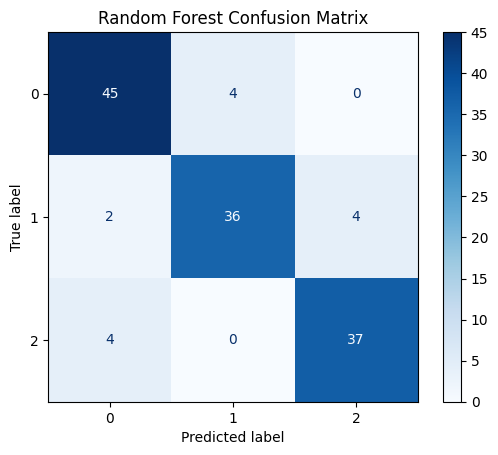

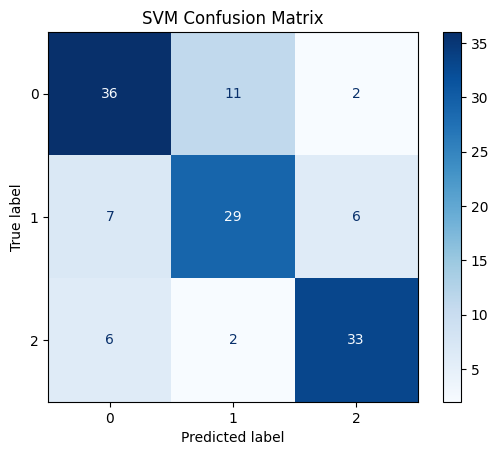

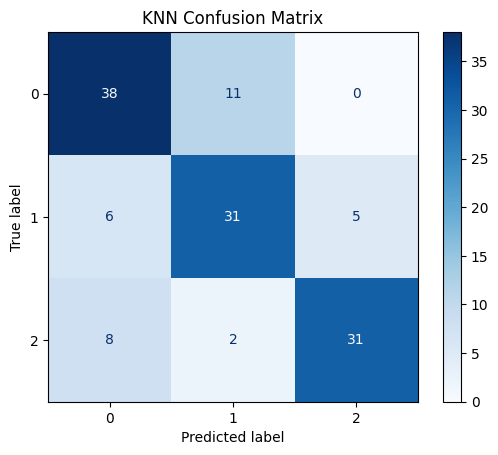

In [194]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")